In [ ]:
!pip install shap
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
import numpy as np
import shap
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import tensorflow as tf

# Replace this path with the path where your model is saved
model_path = '/content/drive/My Drive/MyModels/TrainedModelForAccuracy'
model = tf.keras.models.load_model(model_path)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.7/535.7 kB 4.3 MB/s eta 0:00:00
Mounted at /content/drive


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


1/1 [==============================] - 1s 663ms/step


The model predicts this MRI scan as: Moderately Demented with confidence: 0.9719874262809753


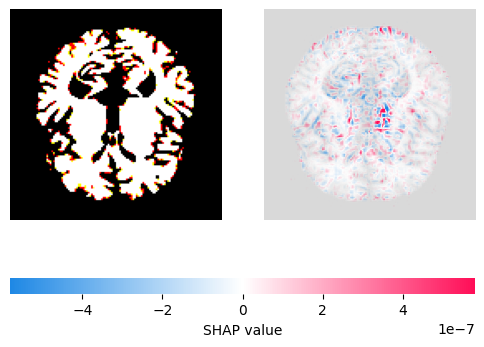

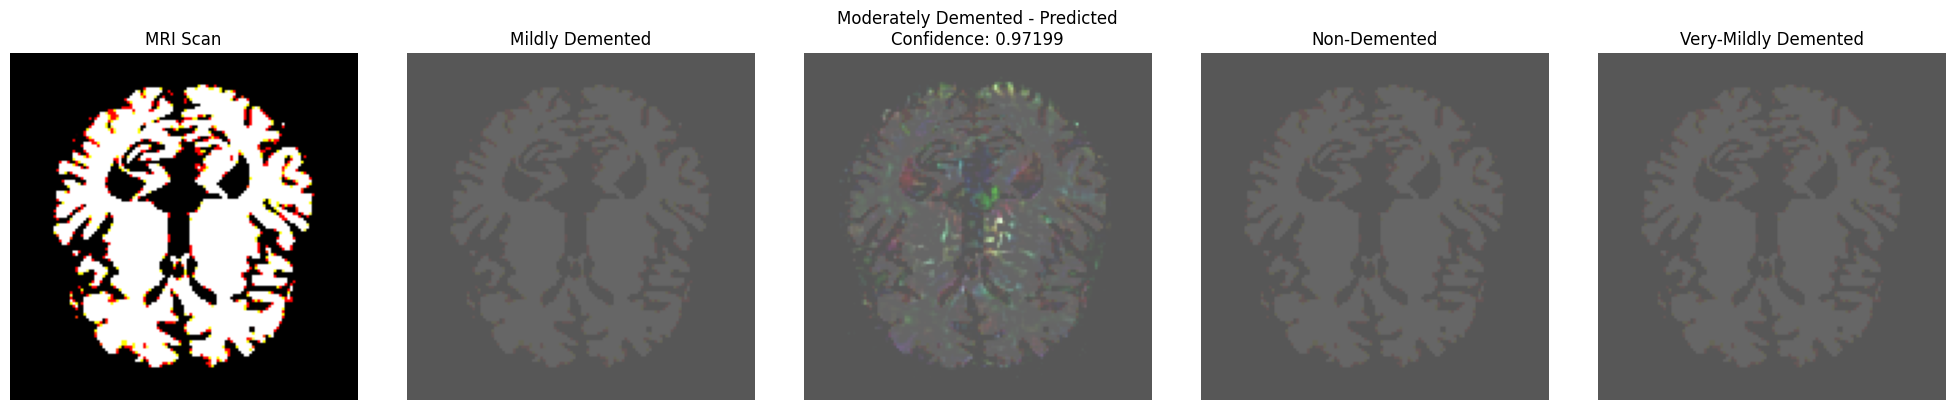

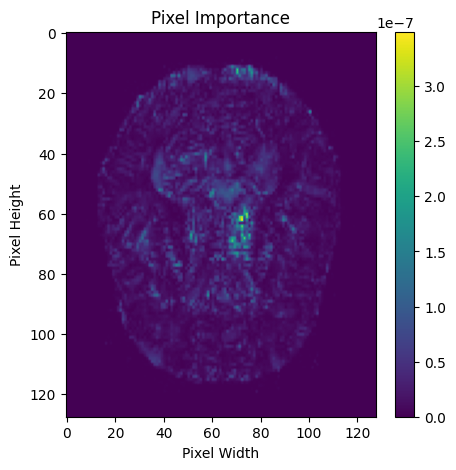

In [ ]:
# Function to load and preprocess images
def load_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Adjust target size as per your model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)  # Preprocess as per VGG16 requirements

# Function to get image paths from subdirectories
def get_image_paths(directory):
    all_image_paths = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_files = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]
            all_image_paths.extend(image_files)
    return all_image_paths

# New path to the subset folder
subset_folder = '/content/drive/My Drive/10_Samples_MRI'

# Load all image paths for the background dataset
background_image_paths = get_image_paths(subset_folder)

# Preprocess all background data
background_data = np.vstack([load_preprocess_image(img_path) for img_path in background_image_paths])

# Load and preprocess sample images for explanation
sample_images=['/content/drive/My Drive/10_Samples_MRI/Moderate/Copy of moderate_26.jpg']
preprocessed_samples = np.vstack([load_preprocess_image(img_path) for img_path in sample_images])

# Assuming 'model' is already loaded
# Using GradientExplainer
explainer = shap.GradientExplainer(model, background_data)

# Compute SHAP values
shap_values = explainer.shap_values(preprocessed_samples)

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Replace with the path to your MRI scan image
sample_image_path = '/content/drive/My Drive/10_Samples_MRI/Moderate/Copy of moderate_26.jpg'
preprocessed_image = preprocess_image(sample_image_path, target_size=(128, 128))

prediction = model.predict(preprocessed_image)

# Assuming you have the class names stored in a list called class_names
class_names = ['Mildly Demented', 'Moderately Demented', 'Non-Demented', 'Very-Mildly Demented']  # Replace with your actual class names
predicted_class = class_names[np.argmax(prediction)]

print(f"The model predicts this MRI scan as: {predicted_class} with confidence: {np.max(prediction)}")

# Sum the absolute values of the SHAP values for each class
summed_shap_values = [np.sum(np.abs(sv)) for sv in shap_values]

# Find the index of the class with the highest SHAP value sum
selected_class_index = np.argmax(summed_shap_values)

# Plot the explanations for the selected class
shap.image_plot(shap_values[selected_class_index], preprocessed_samples)

import matplotlib.pyplot as plt

# ... [rest of the code remains the same] ...
selected_class_index = np.argmax(summed_shap_values)

# Predicted class index from the model's prediction
predicted_class_index = np.argmax(prediction)

# Create an array to store the SHAP values for plotting
shap_values_for_plotting = [np.zeros_like(shap_values[0][0]) for _ in range(len(class_names))]
shap_values_for_plotting[predicted_class_index] = shap_values[selected_class_index][0]

# Function to plot the MRI and SHAP values
def plot_mri_and_shap(mri_image, shap_values, predicted_class_index, class_names, confidence_score):
    # Create a figure with subplots in 1 row and 5 columns
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    # Plot the original MRI scan
    axes[0].imshow(mri_image.squeeze(), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title("MRI Scan")

    # Plot the SHAP values in the respective subplots
    for i, sv in enumerate(shap_values):
        axes[i+1].imshow(mri_image.squeeze(), cmap='gray', alpha=0.15)  # Show the MRI scan as a background
        sv_normalized = sv if sv.max() == 0 else sv / sv.max()  # Normalize only if max is not zero
        axes[i+1].imshow(sv_normalized, cmap='coolwarm', alpha=0.6)  # Overlay the SHAP values
        axes[i+1].axis('off')

        # Check if this is the predicted class and add 'Predicted' label and confidence score
        if i == predicted_class_index:
            title = f"{class_names[i]} - Predicted\nConfidence: {confidence_score:.5f}"
        else:
            title = class_names[i]

        axes[i+1].set_title(title)

    plt.tight_layout()
    plt.show()

# Get the confidence score for the predicted class
confidence_score = np.max(prediction)

# Call the plotting function
plot_mri_and_shap(preprocessed_samples, shap_values_for_plotting, predicted_class_index, class_names, confidence_score)

# Ensure you have the SHAP values for the selected class
# This should be a 3D array of shape (1, 128, 128, 3) for RGB images or (1, 128, 128) for grayscale
shap_values_for_class = shap_values[selected_class_index][0]

# For RGB images, we typically average the absolute SHAP values across the color channels
if len(shap_values_for_class.shape) == 3 and shap_values_for_class.shape[2] == 3:
    shap_values_for_class = np.abs(shap_values_for_class).mean(axis=-1)

# Now, shap_values_for_class should be a 2D array of shape (128, 128)
# Plotting the pixel importance
plt.figure(figsize=(5, 5))
plt.imshow(shap_values_for_class, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Pixel Importance')
plt.xlabel('Pixel Width')
plt.ylabel('Pixel Height')
plt.show()

# Create the directory for saving the SHAP values if it doesn't exist
save_dir = '/content/drive/My Drive/SHAPvalues'
os.makedirs(save_dir, exist_ok=True)  # This creates the directory if it doesn't exist

# Now save the SHAP values
np.save(os.path.join(save_dir, 'Copy of moderate_26.npy'), np.array(shap_values[selected_class_index]))

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


1/1 [==============================] - 1s 631ms/step


The model predicts this MRI scan as: Moderately Demented with confidence: 0.9837123155593872


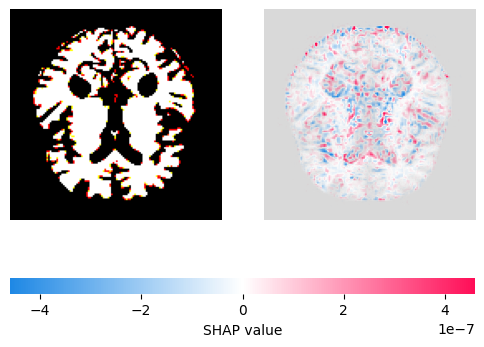

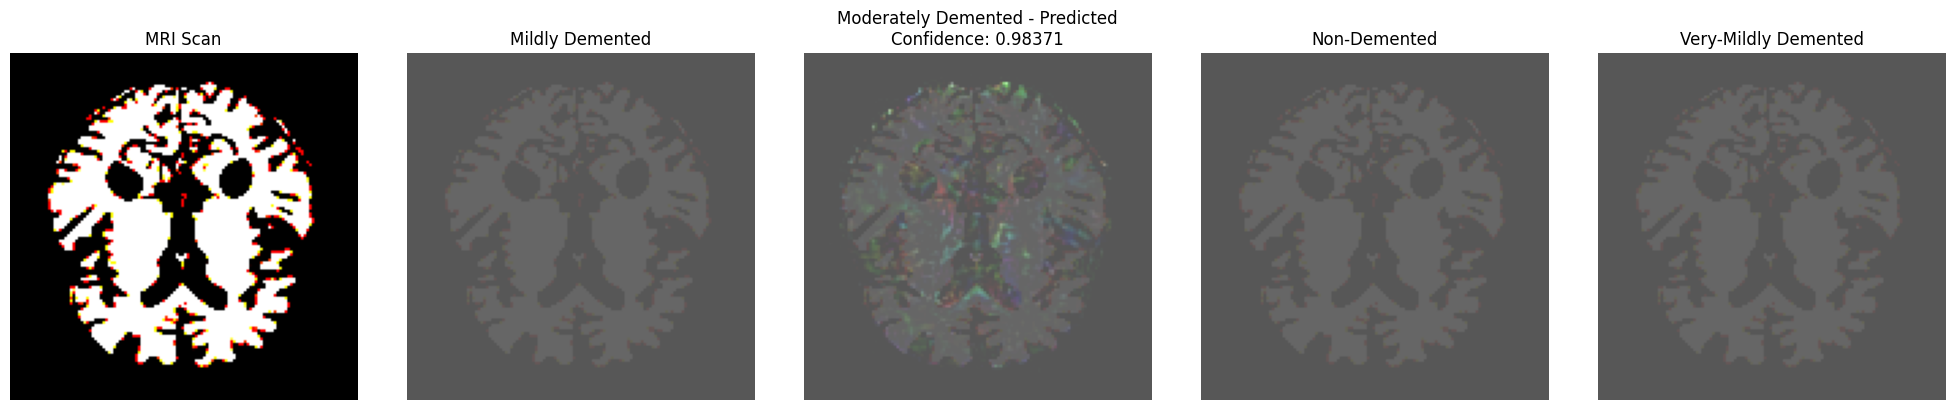

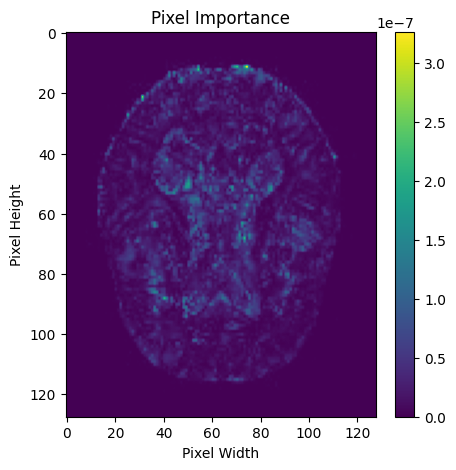

In [ ]:
# Function to load and preprocess images
def load_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Adjust target size as per your model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)  # Preprocess as per VGG16 requirements

# Function to get image paths from subdirectories
def get_image_paths(directory):
    all_image_paths = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_files = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]
            all_image_paths.extend(image_files)
    return all_image_paths

# New path to the subset folder
subset_folder = '/content/drive/My Drive/10_Samples_MRI'

# Load all image paths for the background dataset
background_image_paths = get_image_paths(subset_folder)

# Preprocess all background data
background_data = np.vstack([load_preprocess_image(img_path) for img_path in background_image_paths])

# Load and preprocess sample images for explanation
sample_images=['/content/drive/My Drive/10_Samples_MRI/Moderate/Copy of moderate_27.jpg']
preprocessed_samples = np.vstack([load_preprocess_image(img_path) for img_path in sample_images])

# Assuming 'model' is already loaded
# Using GradientExplainer
explainer = shap.GradientExplainer(model, background_data)

# Compute SHAP values
shap_values = explainer.shap_values(preprocessed_samples)

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Replace with the path to your MRI scan image
sample_image_path = '/content/drive/My Drive/10_Samples_MRI/Moderate/Copy of moderate_27.jpg'
preprocessed_image = preprocess_image(sample_image_path, target_size=(128, 128))

prediction = model.predict(preprocessed_image)

# Assuming you have the class names stored in a list called class_names
class_names = ['Mildly Demented', 'Moderately Demented', 'Non-Demented', 'Very-Mildly Demented']  # Replace with your actual class names
predicted_class = class_names[np.argmax(prediction)]

print(f"The model predicts this MRI scan as: {predicted_class} with confidence: {np.max(prediction)}")

# Sum the absolute values of the SHAP values for each class
summed_shap_values = [np.sum(np.abs(sv)) for sv in shap_values]

# Find the index of the class with the highest SHAP value sum
selected_class_index = np.argmax(summed_shap_values)

# Plot the explanations for the selected class
shap.image_plot(shap_values[selected_class_index], preprocessed_samples)

import matplotlib.pyplot as plt

# ... [rest of the code remains the same] ...
selected_class_index = np.argmax(summed_shap_values)

# Predicted class index from the model's prediction
predicted_class_index = np.argmax(prediction)

# Create an array to store the SHAP values for plotting
shap_values_for_plotting = [np.zeros_like(shap_values[0][0]) for _ in range(len(class_names))]
shap_values_for_plotting[predicted_class_index] = shap_values[selected_class_index][0]

# Function to plot the MRI and SHAP values
def plot_mri_and_shap(mri_image, shap_values, predicted_class_index, class_names, confidence_score):
    # Create a figure with subplots in 1 row and 5 columns
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    # Plot the original MRI scan
    axes[0].imshow(mri_image.squeeze(), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title("MRI Scan")

    # Plot the SHAP values in the respective subplots
    for i, sv in enumerate(shap_values):
        axes[i+1].imshow(mri_image.squeeze(), cmap='gray', alpha=0.15)  # Show the MRI scan as a background
        sv_normalized = sv if sv.max() == 0 else sv / sv.max()  # Normalize only if max is not zero
        axes[i+1].imshow(sv_normalized, cmap='coolwarm', alpha=0.6)  # Overlay the SHAP values
        axes[i+1].axis('off')

        # Check if this is the predicted class and add 'Predicted' label and confidence score
        if i == predicted_class_index:
            title = f"{class_names[i]} - Predicted\nConfidence: {confidence_score:.5f}"
        else:
            title = class_names[i]

        axes[i+1].set_title(title)

    plt.tight_layout()
    plt.show()

# Get the confidence score for the predicted class
confidence_score = np.max(prediction)

# Call the plotting function
plot_mri_and_shap(preprocessed_samples, shap_values_for_plotting, predicted_class_index, class_names, confidence_score)

# Ensure you have the SHAP values for the selected class
# This should be a 3D array of shape (1, 128, 128, 3) for RGB images or (1, 128, 128) for grayscale
shap_values_for_class = shap_values[selected_class_index][0]

# For RGB images, we typically average the absolute SHAP values across the color channels
if len(shap_values_for_class.shape) == 3 and shap_values_for_class.shape[2] == 3:
    shap_values_for_class = np.abs(shap_values_for_class).mean(axis=-1)

# Now, shap_values_for_class should be a 2D array of shape (128, 128)
# Plotting the pixel importance
plt.figure(figsize=(5, 5))
plt.imshow(shap_values_for_class, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Pixel Importance')
plt.xlabel('Pixel Width')
plt.ylabel('Pixel Height')
plt.show()

# Create the directory for saving the SHAP values if it doesn't exist
save_dir = '/content/drive/My Drive/SHAPvalues'
os.makedirs(save_dir, exist_ok=True)  # This creates the directory if it doesn't exist

# Now save the SHAP values
np.save(os.path.join(save_dir, 'Copy of moderate_27.npy'), np.array(shap_values[selected_class_index]))

1/1 [==============================] - 0s 196ms/step


The model predicts this MRI scan as: Moderately Demented with confidence: 0.998954176902771


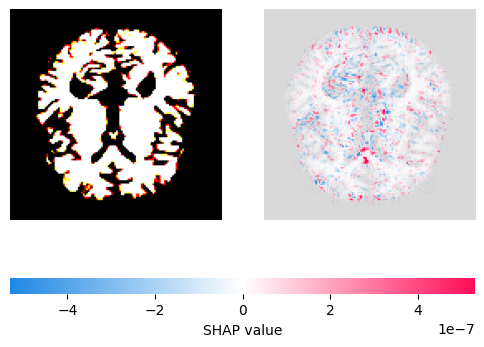

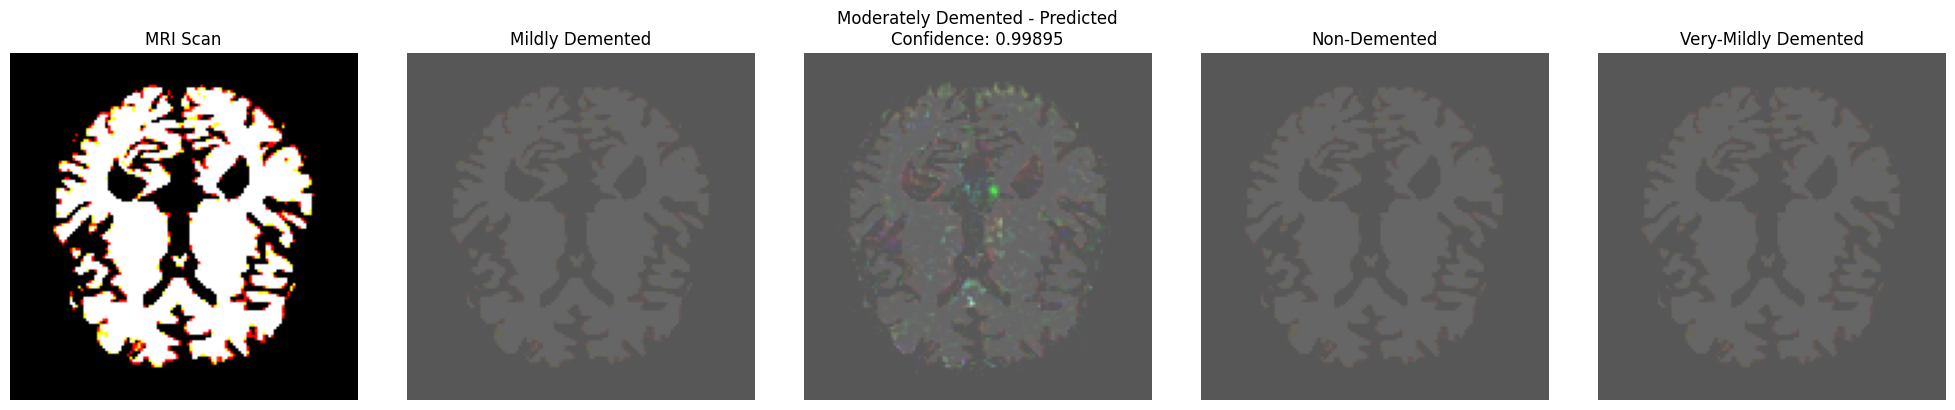

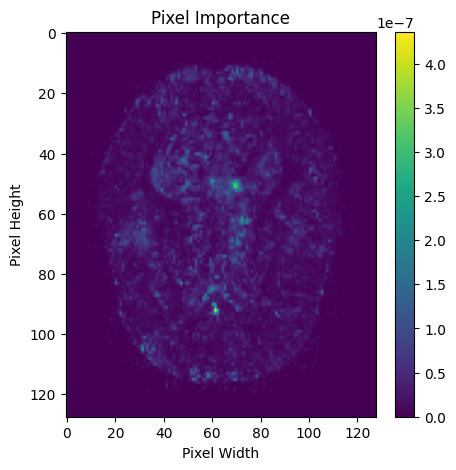

In [ ]:
# Function to load and preprocess images
def load_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Adjust target size as per your model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)  # Preprocess as per VGG16 requirements

# Function to get image paths from subdirectories
def get_image_paths(directory):
    all_image_paths = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_files = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]
            all_image_paths.extend(image_files)
    return all_image_paths

# New path to the subset folder
subset_folder = '/content/drive/My Drive/10_Samples_MRI'

# Load all image paths for the background dataset
background_image_paths = get_image_paths(subset_folder)

# Preprocess all background data
background_data = np.vstack([load_preprocess_image(img_path) for img_path in background_image_paths])

# Load and preprocess sample images for explanation
sample_images=['/content/drive/My Drive/10_Samples_MRI/Moderate/Copy of moderate_28.jpg']
preprocessed_samples = np.vstack([load_preprocess_image(img_path) for img_path in sample_images])

# Assuming 'model' is already loaded
# Using GradientExplainer
explainer = shap.GradientExplainer(model, background_data)

# Compute SHAP values
shap_values = explainer.shap_values(preprocessed_samples)

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Replace with the path to your MRI scan image
sample_image_path = '/content/drive/My Drive/10_Samples_MRI/Moderate/Copy of moderate_28.jpg'
preprocessed_image = preprocess_image(sample_image_path, target_size=(128, 128))

prediction = model.predict(preprocessed_image)

# Assuming you have the class names stored in a list called class_names
class_names = ['Mildly Demented', 'Moderately Demented', 'Non-Demented', 'Very-Mildly Demented']  # Replace with your actual class names
predicted_class = class_names[np.argmax(prediction)]

print(f"The model predicts this MRI scan as: {predicted_class} with confidence: {np.max(prediction)}")

# Sum the absolute values of the SHAP values for each class
summed_shap_values = [np.sum(np.abs(sv)) for sv in shap_values]

# Find the index of the class with the highest SHAP value sum
selected_class_index = np.argmax(summed_shap_values)

# Plot the explanations for the selected class
shap.image_plot(shap_values[selected_class_index], preprocessed_samples)

import matplotlib.pyplot as plt

# ... [rest of the code remains the same] ...
selected_class_index = np.argmax(summed_shap_values)

# Predicted class index from the model's prediction
predicted_class_index = np.argmax(prediction)

# Create an array to store the SHAP values for plotting
shap_values_for_plotting = [np.zeros_like(shap_values[0][0]) for _ in range(len(class_names))]
shap_values_for_plotting[predicted_class_index] = shap_values[selected_class_index][0]

# Function to plot the MRI and SHAP values
def plot_mri_and_shap(mri_image, shap_values, predicted_class_index, class_names, confidence_score):
    # Create a figure with subplots in 1 row and 5 columns
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    # Plot the original MRI scan
    axes[0].imshow(mri_image.squeeze(), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title("MRI Scan")

    # Plot the SHAP values in the respective subplots
    for i, sv in enumerate(shap_values):
        axes[i+1].imshow(mri_image.squeeze(), cmap='gray', alpha=0.15)  # Show the MRI scan as a background
        sv_normalized = sv if sv.max() == 0 else sv / sv.max()  # Normalize only if max is not zero
        axes[i+1].imshow(sv_normalized, cmap='coolwarm', alpha=0.6)  # Overlay the SHAP values
        axes[i+1].axis('off')

        # Check if this is the predicted class and add 'Predicted' label and confidence score
        if i == predicted_class_index:
            title = f"{class_names[i]} - Predicted\nConfidence: {confidence_score:.5f}"
        else:
            title = class_names[i]

        axes[i+1].set_title(title)

    plt.tight_layout()
    plt.show()

# Get the confidence score for the predicted class
confidence_score = np.max(prediction)

# Call the plotting function
plot_mri_and_shap(preprocessed_samples, shap_values_for_plotting, predicted_class_index, class_names, confidence_score)

# Ensure you have the SHAP values for the selected class
# This should be a 3D array of shape (1, 128, 128, 3) for RGB images or (1, 128, 128) for grayscale
shap_values_for_class = shap_values[selected_class_index][0]

# For RGB images, we typically average the absolute SHAP values across the color channels
if len(shap_values_for_class.shape) == 3 and shap_values_for_class.shape[2] == 3:
    shap_values_for_class = np.abs(shap_values_for_class).mean(axis=-1)

# Now, shap_values_for_class should be a 2D array of shape (128, 128)
# Plotting the pixel importance
plt.figure(figsize=(5, 5))
plt.imshow(shap_values_for_class, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Pixel Importance')
plt.xlabel('Pixel Width')
plt.ylabel('Pixel Height')
plt.show()

# Create the directory for saving the SHAP values if it doesn't exist
save_dir = '/content/drive/My Drive/SHAPvalues'
os.makedirs(save_dir, exist_ok=True)  # This creates the directory if it doesn't exist

# Now save the SHAP values
np.save(os.path.join(save_dir, 'Copy of moderate_28.npy'), np.array(shap_values[selected_class_index]))

1/1 [==============================] - 1s 554ms/step
The model predicts this MRI scan as: Moderately Demented with confidence: 0.99965500831604


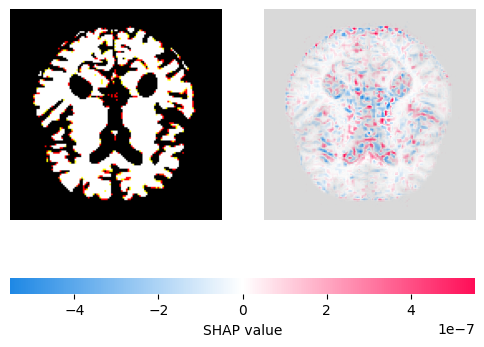

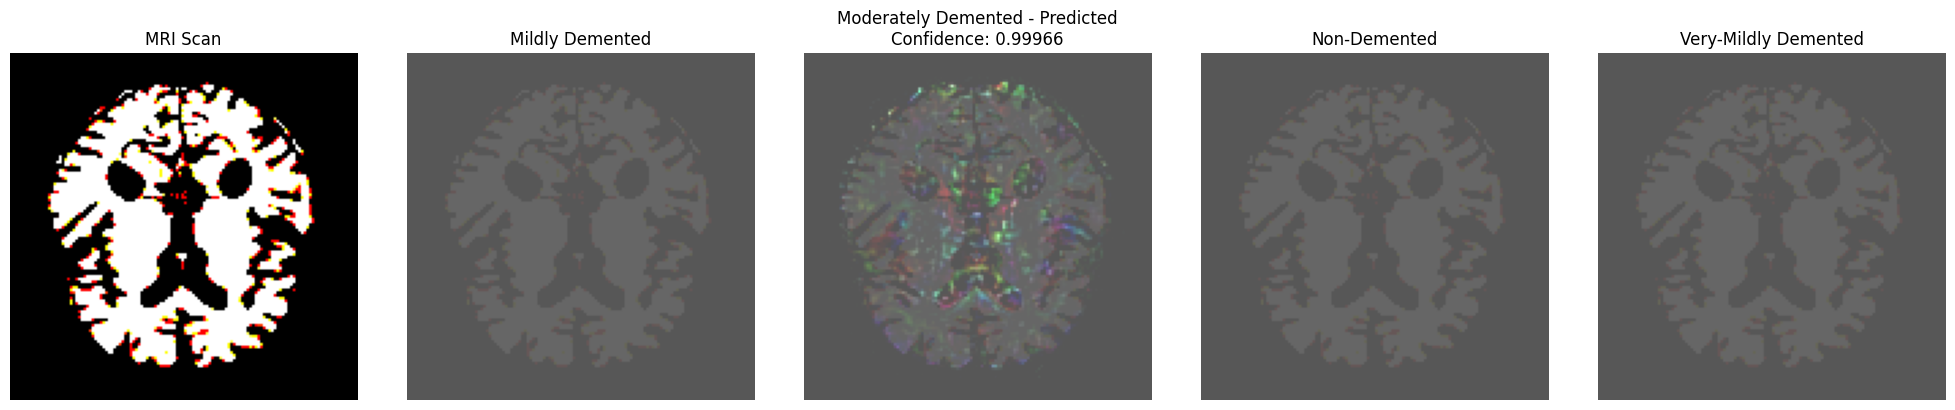

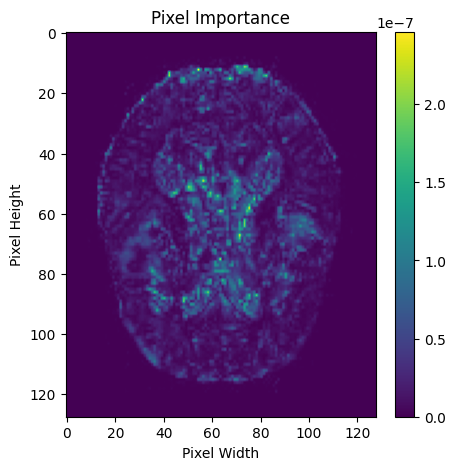

In [ ]:
# Function to load and preprocess images
def load_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Adjust target size as per your model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)  # Preprocess as per VGG16 requirements

# Function to get image paths from subdirectories
def get_image_paths(directory):
    all_image_paths = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_files = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]
            all_image_paths.extend(image_files)
    return all_image_paths

# New path to the subset folder
subset_folder = '/content/drive/My Drive/10_Samples_MRI'

# Load all image paths for the background dataset
background_image_paths = get_image_paths(subset_folder)

# Preprocess all background data
background_data = np.vstack([load_preprocess_image(img_path) for img_path in background_image_paths])

# Load and preprocess sample images for explanation
sample_images=['/content/drive/My Drive/10_Samples_MRI/Moderate/Copy of moderate_29.jpg']
preprocessed_samples = np.vstack([load_preprocess_image(img_path) for img_path in sample_images])

# Assuming 'model' is already loaded
# Using GradientExplainer
explainer = shap.GradientExplainer(model, background_data)

# Compute SHAP values
shap_values = explainer.shap_values(preprocessed_samples)

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Replace with the path to your MRI scan image
sample_image_path = '/content/drive/My Drive/10_Samples_MRI/Moderate/Copy of moderate_29.jpg'
preprocessed_image = preprocess_image(sample_image_path, target_size=(128, 128))

prediction = model.predict(preprocessed_image)

# Assuming you have the class names stored in a list called class_names
class_names = ['Mildly Demented', 'Moderately Demented', 'Non-Demented', 'Very-Mildly Demented']  # Replace with your actual class names
predicted_class = class_names[np.argmax(prediction)]

print(f"The model predicts this MRI scan as: {predicted_class} with confidence: {np.max(prediction)}")

# Sum the absolute values of the SHAP values for each class
summed_shap_values = [np.sum(np.abs(sv)) for sv in shap_values]

# Find the index of the class with the highest SHAP value sum
selected_class_index = np.argmax(summed_shap_values)

# Plot the explanations for the selected class
shap.image_plot(shap_values[selected_class_index], preprocessed_samples)

import matplotlib.pyplot as plt

# ... [rest of the code remains the same] ...
selected_class_index = np.argmax(summed_shap_values)

# Predicted class index from the model's prediction
predicted_class_index = np.argmax(prediction)

# Create an array to store the SHAP values for plotting
shap_values_for_plotting = [np.zeros_like(shap_values[0][0]) for _ in range(len(class_names))]
shap_values_for_plotting[predicted_class_index] = shap_values[selected_class_index][0]

# Function to plot the MRI and SHAP values
def plot_mri_and_shap(mri_image, shap_values, predicted_class_index, class_names, confidence_score):
    # Create a figure with subplots in 1 row and 5 columns
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    # Plot the original MRI scan
    axes[0].imshow(mri_image.squeeze(), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title("MRI Scan")

    # Plot the SHAP values in the respective subplots
    for i, sv in enumerate(shap_values):
        axes[i+1].imshow(mri_image.squeeze(), cmap='gray', alpha=0.15)  # Show the MRI scan as a background
        sv_normalized = sv if sv.max() == 0 else sv / sv.max()  # Normalize only if max is not zero
        axes[i+1].imshow(sv_normalized, cmap='coolwarm', alpha=0.6)  # Overlay the SHAP values
        axes[i+1].axis('off')

        # Check if this is the predicted class and add 'Predicted' label and confidence score
        if i == predicted_class_index:
            title = f"{class_names[i]} - Predicted\nConfidence: {confidence_score:.5f}"
        else:
            title = class_names[i]

        axes[i+1].set_title(title)

    plt.tight_layout()
    plt.show()

# Get the confidence score for the predicted class
confidence_score = np.max(prediction)

# Call the plotting function
plot_mri_and_shap(preprocessed_samples, shap_values_for_plotting, predicted_class_index, class_names, confidence_score)

# Ensure you have the SHAP values for the selected class
# This should be a 3D array of shape (1, 128, 128, 3) for RGB images or (1, 128, 128) for grayscale
shap_values_for_class = shap_values[selected_class_index][0]

# For RGB images, we typically average the absolute SHAP values across the color channels
if len(shap_values_for_class.shape) == 3 and shap_values_for_class.shape[2] == 3:
    shap_values_for_class = np.abs(shap_values_for_class).mean(axis=-1)

# Now, shap_values_for_class should be a 2D array of shape (128, 128)
# Plotting the pixel importance
plt.figure(figsize=(5, 5))
plt.imshow(shap_values_for_class, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Pixel Importance')
plt.xlabel('Pixel Width')
plt.ylabel('Pixel Height')
plt.show()

# Create the directory for saving the SHAP values if it doesn't exist
save_dir = '/content/drive/My Drive/SHAPvalues'
os.makedirs(save_dir, exist_ok=True)  # This creates the directory if it doesn't exist

# Now save the SHAP values
np.save(os.path.join(save_dir, 'Copy of moderate_29.npy'), np.array(shap_values[selected_class_index]))

1/1 [==============================] - 0s 344ms/step


The model predicts this MRI scan as: Moderately Demented with confidence: 0.9939524531364441


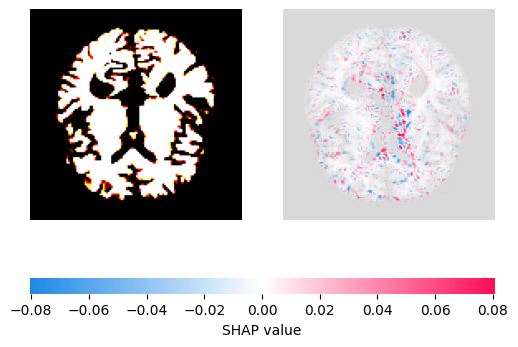

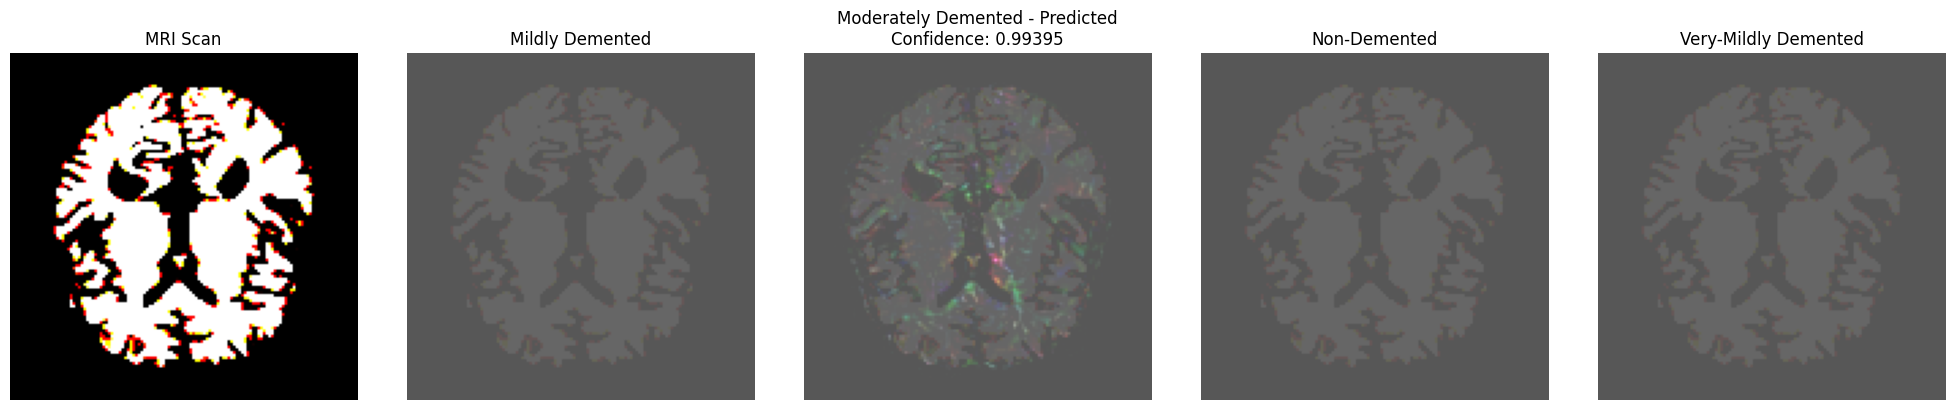

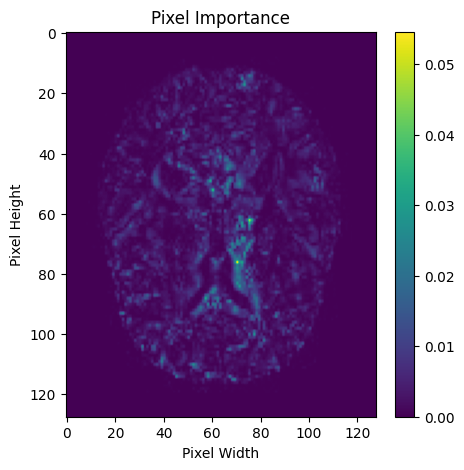

In [ ]:
# Function to load and preprocess images
def load_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Adjust target size as per your model input
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)  # Preprocess as per VGG16 requirements

# Function to get image paths from subdirectories
def get_image_paths(directory):
    all_image_paths = []
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            image_files = [os.path.join(subdir_path, f) for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))]
            all_image_paths.extend(image_files)
    return all_image_paths

# New path to the subset folder
subset_folder = '/content/drive/My Drive/10_Samples_MRI'

# Load all image paths for the background dataset
background_image_paths = get_image_paths(subset_folder)

# Preprocess all background data
background_data = np.vstack([load_preprocess_image(img_path) for img_path in background_image_paths])

# Load and preprocess sample images for explanation
sample_images=['/content/drive/My Drive/10_Samples_MRI/Moderate/Copy of moderate_30.jpg']
preprocessed_samples = np.vstack([load_preprocess_image(img_path) for img_path in sample_images])

# Assuming 'model' is already loaded
# Using GradientExplainer
explainer = shap.GradientExplainer(model, background_data)

# Compute SHAP values
shap_values = explainer.shap_values(preprocessed_samples)

from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Replace with the path to your MRI scan image
sample_image_path = '/content/drive/My Drive/10_Samples_MRI/Moderate/Copy of moderate_30.jpg'
preprocessed_image = preprocess_image(sample_image_path, target_size=(128, 128))

prediction = model.predict(preprocessed_image)

# Assuming you have the class names stored in a list called class_names
class_names = ['Mildly Demented', 'Moderately Demented', 'Non-Demented', 'Very-Mildly Demented']  # Replace with your actual class names
predicted_class = class_names[np.argmax(prediction)]

print(f"The model predicts this MRI scan as: {predicted_class} with confidence: {np.max(prediction)}")

# Sum the absolute values of the SHAP values for each class
summed_shap_values = [np.sum(np.abs(sv)) for sv in shap_values]

# Find the index of the class with the highest SHAP value sum
selected_class_index = np.argmax(summed_shap_values)

# Plot the explanations for the selected class
shap.image_plot(shap_values[selected_class_index], preprocessed_samples)

import matplotlib.pyplot as plt

# ... [rest of the code remains the same] ...
selected_class_index = np.argmax(summed_shap_values)

# Predicted class index from the model's prediction
predicted_class_index = np.argmax(prediction)

# Create an array to store the SHAP values for plotting
shap_values_for_plotting = [np.zeros_like(shap_values[0][0]) for _ in range(len(class_names))]
shap_values_for_plotting[predicted_class_index] = shap_values[selected_class_index][0]

# Function to plot the MRI and SHAP values
def plot_mri_and_shap(mri_image, shap_values, predicted_class_index, class_names, confidence_score):
    # Create a figure with subplots in 1 row and 5 columns
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))

    # Plot the original MRI scan
    axes[0].imshow(mri_image.squeeze(), cmap='gray')
    axes[0].axis('off')
    axes[0].set_title("MRI Scan")

    # Plot the SHAP values in the respective subplots
    for i, sv in enumerate(shap_values):
        axes[i+1].imshow(mri_image.squeeze(), cmap='gray', alpha=0.15)  # Show the MRI scan as a background
        sv_normalized = sv if sv.max() == 0 else sv / sv.max()  # Normalize only if max is not zero
        axes[i+1].imshow(sv_normalized, cmap='coolwarm', alpha=0.6)  # Overlay the SHAP values
        axes[i+1].axis('off')

        # Check if this is the predicted class and add 'Predicted' label and confidence score
        if i == predicted_class_index:
            title = f"{class_names[i]} - Predicted\nConfidence: {confidence_score:.5f}"
        else:
            title = class_names[i]

        axes[i+1].set_title(title)

    plt.tight_layout()
    plt.show()

# Get the confidence score for the predicted class
confidence_score = np.max(prediction)

# Call the plotting function
plot_mri_and_shap(preprocessed_samples, shap_values_for_plotting, predicted_class_index, class_names, confidence_score)

# Ensure you have the SHAP values for the selected class
# This should be a 3D array of shape (1, 128, 128, 3) for RGB images or (1, 128, 128) for grayscale
shap_values_for_class = shap_values[selected_class_index][0]

# For RGB images, we typically average the absolute SHAP values across the color channels
if len(shap_values_for_class.shape) == 3 and shap_values_for_class.shape[2] == 3:
    shap_values_for_class = np.abs(shap_values_for_class).mean(axis=-1)

# Now, shap_values_for_class should be a 2D array of shape (128, 128)
# Plotting the pixel importance
plt.figure(figsize=(5, 5))
plt.imshow(shap_values_for_class, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Pixel Importance')
plt.xlabel('Pixel Width')
plt.ylabel('Pixel Height')
plt.show()

# Create the directory for saving the SHAP values if it doesn't exist
save_dir = '/content/drive/My Drive/SHAPvalues'
os.makedirs(save_dir, exist_ok=True)  # This creates the directory if it doesn't exist

# Now save the SHAP values
np.save(os.path.join(save_dir, 'Copy of moderate_30.npy'), np.array(shap_values[selected_class_index]))